In [1]:
import numpy as np
import collections
import gzip

from scipy import stats
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
#plt.switch_backend('agg')
import matplotlib
import sys
sys.path.append('../')
from utils import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 18, colors = 'banskt', dpi = 72)

In [2]:
f_gx_qn= "/scratch/sbanerj/trans-eqtl/input/gtex/expression/gtex_protein_coding_normalized_esom.txt"
f_gx_qn_lm = "/scratch/sbanerj/trans-eqtl/input/gtex/expression/gtex_protein_coding_normalized_lmcorrected_withage_esom.txt"
f_vcf = "/scratch/sbanerj/trans-eqtl/input/gtex/genotype/all_samples/GTEx_v6_imput_info04_HWEp1E6_PASS_dbSNP135_maf1_noindels_noambig_chr5.vcf.gz"

In [3]:
SNPINFO_FIELDS = ['chrom', 'varid', 'bp_pos', 'ref_allele', 'alt_allele', 'maf']
class SnpInfo(collections.namedtuple('_SnpInfo', SNPINFO_FIELDS)):
    __slots__ = ()


def read_gtex(filename):
    expr_list = list()
    donor_list = list()
    gene_list = list()
    with open(filename) as mfile:
        donor_list = mfile.readline().strip().split("\t")[1:]
        for line in mfile:
            linesplit = line.strip().split("\t")
            gene = linesplit[0].strip()
            gene_list.append(gene)
            expr = np.array([float(x) for x in linesplit[1:]])
            expr_list.append(expr)
    expr = np.transpose(np.array(expr_list))
    return expr, donor_list, gene_list

def read_vcf(filename, startsnp, endsnp):
    dosage = list()
    snpinfo = list()
    linenum = 0
    with gzip.open(filename, 'r') as vcf:
        for line in vcf:
            linestrip = line.decode().strip()
            if linestrip[:2] == '##': continue
            if linestrip[:6] == '#CHROM':
                linesplit = linestrip.split("\t")
                donor_ids = linesplit[9:]
            else:
                if linenum >= startsnp and linenum < endsnp:
                    linesplit = linestrip.split("\t")
                    chrom = int(linesplit[0])
                    pos   = int(linesplit[1])
                    varid = linesplit[2]
                    ref   = linesplit[3]
                    alt   = linesplit[4]

                    dsindx = linesplit[8].split(':').index("DS")
                    ds = [x.split(':')[dsindx] for x in linesplit[9:]]
                    gtindx = linesplit[8].split(':').index("GT")
                    for i, x in enumerate(ds):
                        if x == ".":
                            gt = linesplit[9+i].split(':')[gtindx]
                            if len(gt) == 3 and gt[0] != "." and gt[2] != ".":
                                ds[i] = float(int(gt[0]) + int(gt[2]))

                    ds_notna = [float(x) for x in ds if x != "."]
                    freq = sum(ds_notna) / 2 / len(ds_notna)
                    maf = freq
                    snpdosage = [float(x) if x != '.' else 2 * freq for x in ds]

                    this_snp = SnpInfo(chrom      = chrom,
                                       bp_pos     = pos,
                                       varid      = varid,
                                       ref_allele = ref,
                                       alt_allele = alt,
                                       maf        = maf)

                    dosage.append(snpdosage)
                    snpinfo.append(this_snp)
                linenum += 1

    return np.array(dosage), snpinfo, donor_ids


def normalize_expr(Y):
    newY = (Y - np.mean(Y, axis = 1).reshape(-1, 1)) / np.std(Y, axis = 1).reshape(-1, 1)
    return newY

def select_donors(vcf_donors, expr_donors):
    ''' Make sure that donors are in the same order for both expression and genotype
    '''
    common_donors = [x for x in vcf_donors if x in expr_donors]
    vcfmask = np.array([vcf_donors.index(x) for x in common_donors])
    exprmask = np.array([expr_donors.index(x) for x in common_donors])
    return vcfmask, exprmask

def normalize_and_center_dosage(dosage, snpinfo):
    f = [snp.maf for snp in snpinfo]
    f = np.array(f).reshape(-1, 1)
    gtcent = dosage - np.mean(dosage, axis = 1).reshape(-1, 1)
    return gtcent

In [4]:
gtfull, snp_info, gt_donors = read_vcf(f_vcf, 0, 3)
newdosage = list()
for i, snp in enumerate(snp_info):
    bins = [0.66, 1.33]
    intdosage = np.digitize(gtfull[i], bins)
    newdosage.append(intdosage)
gtint = np.array(newdosage)
#gtint = np.array(gtfull)

In [5]:
gx_qn, gx_donors, _ = read_gtex(f_gx_qn)
gx_qn_lm, _, _ = read_gtex(f_gx_qn_lm)

In [21]:
gx_rand = np.random.normal(0, 1, size = gx_qn.shape[0] * gx_qn.shape[1]).reshape(gx_qn.shape)

In [23]:
from sklearn.decomposition import PCA
nComp = 5
pca = PCA()
pca.fit(gx_qn.T)
gx_qn_pca = np.dot(pca.transform(gx_qn.T)[:, nComp:], pca.components_[nComp:,:]).T

pca.fit(gx_rand.T)
gx_rand_pca = np.dot(pca.transform(gx_rand.T)[:, nComp:], pca.components_[nComp:,:]).T

In [24]:
gx_qn_norm_nomask = normalize_expr(gx_qn.T)
gx_qn_lm_norm_nomask = normalize_expr(gx_qn_lm.T)
gx_qn_pca_norm_nomask = normalize_expr(gx_qn_pca.T)

gx_rand_nomask = normalize_expr(gx_rand.T)
gx_rand_pca_nomask = normalize_expr(gx_rand_pca.T)

In [25]:
vcfmask, exprmask = select_donors(gt_donors, gx_donors)
gx_qn_norm = gx_qn_norm_nomask[:, exprmask]
gx_qn_lm_norm = gx_qn_lm_norm_nomask[:, exprmask]
gx_qn_pca_norm = gx_qn_pca_norm_nomask[:, exprmask]

gx_rand_norm = gx_rand_nomask[:, exprmask]
gx_rand_pca_norm = gx_rand_pca_nomask[:, exprmask]

gt = normalize_and_center_dosage(gtint[:, vcfmask], snp_info)
sigmax2 = np.var(gt, axis = 1)
print(sigmax2)

[0.39971764 0.41555758 0.41476559]


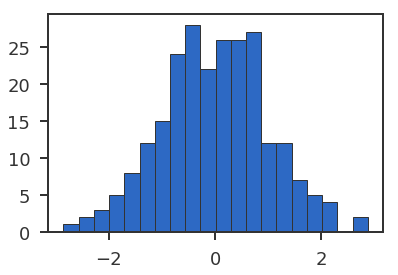

In [8]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.hist(gx_qn_lm_norm[0, :])
plt.show()

In [9]:
def pvals_perm(GT, R, W):
    mu2, mu4 = moment_data(GT)
    N = GT.shape[1]
    q11 = np.sum(W)
    q2  = np.sum(np.diag(W))
    muQ = mu2 * (N * q2 - q11) / (N - 1)

    v31 = - mu4 / (N - 1)
    v22 = v31 + (N * mu2 * mu2 / (N - 1)) #(N*(mu2**2) - mu4)/(N-1)
    v211 = - (v31 + v22) / (N - 2)
    v1111 = - 3 * v211 / (N - 3)

    q31 = np.dot(np.diag(W),np.sum(W,axis = 1))
    q4 = np.sum(np.square(np.diag(W)))
    q22 = np.sum(np.square(W))
    q211 = np.sum(np.square(np.sum(W,axis = 1)))

    sigma2 = v1111*(q11**2 - 2*q2*q11 - 4*q211 + 8*q31 + 2*q22 + q2**2 - 6*q4) + 2*v211*(q2*q11 + 2*q211 - 6*q31 - 2*q22 - q2**2 + 6*q4) + v22*(q2**2 + 2*q22 - 3*q4) + 4*v31*(q31 - q4) + mu4*q4

    sigma2 = sigma2 - muQ**2
    sigmaQ = np.sqrt(sigma2)
    p = 1 - stats.norm.cdf(R, loc=muQ, scale=sigmaQ)
    return p, muQ, sigmaQ

def moment_data(GT):   #GT ixN
    GT2 = np.square(GT)
    GT4 = np.square(GT2)
    mu2 = np.mean(GT2)
    mu4 = np.mean(GT4)
    return mu2, mu4


====== QN ======
Effective dimensions: 240
Sum of S2 / S2mod: 142.162
Qscore: [57.96167505 59.29745337 59.43995916]
muQ: [57.06129017 58.47104378 58.40140126]
sigmaQ: [1.32179889 1.392113   1.38840197]
====== QN_PCA ======
Effective dimensions: 235
Sum of S2 / S2mod: 160.924
Qscore: [66.28467742 68.66700891 68.83337107]
muQ: [64.59220125 66.38189551 66.29330661]
sigmaQ: [1.3568471  1.41942366 1.41617287]
====== Random ======
Effective dimensions: 240
Sum of S2 / S2mod: 191.61
Qscore: [76.88136124 79.2777851  79.14977577]
muQ: [76.90895961 79.32447713 79.2046066 ]
sigmaQ: [0.17292337 0.18392722 0.18337325]
====== Random PCA ======
Effective dimensions: 236
Sum of S2 / S2mod: 188.499
Qscore: [75.98859847 78.85567908 78.70007626]
muQ: [75.66013706 78.04606682 77.92764979]
sigmaQ: [0.99953735 1.03242615 1.03079216]


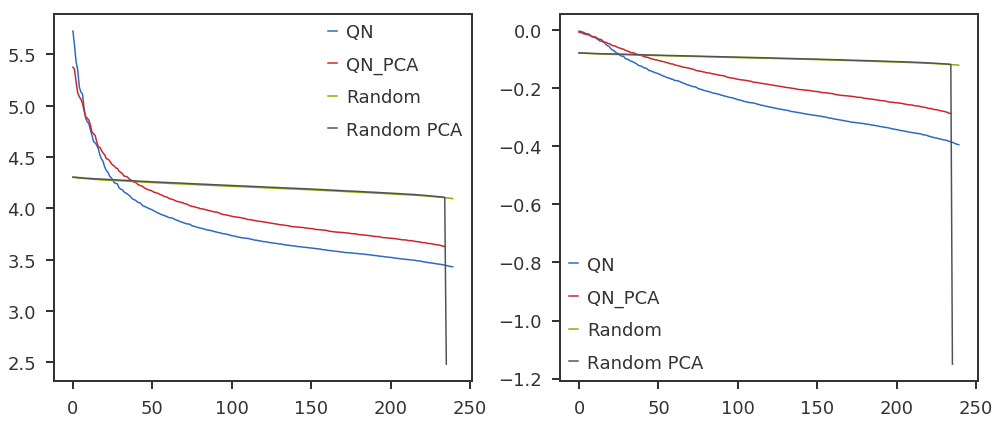

In [26]:
def compare_basic_props(GX, GT, ax1, ax2, label, sigmax2 = [0.01], sigmabeta2 = 0.01 * 0.01):
    Yt = GX.T
    U, S, Vt = np.linalg.svd(Yt, full_matrices=False)
    S2 = np.square(S)
    Keff = len(np.where(S2 > 1)[0])
    #Keff = len(S2)
    print("====== {:s} ======".format(label))
    print("Effective dimensions: {:d}".format(Keff))
    S2mod = S2 + sigmax2[0] / sigmabeta2
    print( "Sum of S2 / S2mod: {:g}".format(np.sum(S2 / S2mod)) )
    
    ax1.plot(np.arange(Keff), np.log10(S2[:Keff]), label = label)
    ax2.plot(np.arange(Keff), np.log10(S2 / S2mod)[:Keff], label = label)
    
    nsnps = GT.shape[0]
    Rscore = np.zeros(nsnps)
    pvals  = np.zeros(nsnps)
    muQ    = np.zeros(nsnps)
    sigmaQ = np.zeros(nsnps)
    for i in range(nsnps):
        S2mod = S2 + sigmax2[i] / sigmabeta2
        W = np.dot(U, np.dot(np.diag(S2 / S2mod), U.T)) #/ sigmax2[i]
        Rscore[i] = np.sum(np.square(np.dot(U.T, GT[i,:])) * S2 / S2mod)
        pvals[i], muQ[i], sigmaQ[i] = pvals_perm(GT[i, :].reshape(1, -1), Rscore[i], W)
        
    print("Qscore:", Rscore)
    print("muQ:", muQ)
    print("sigmaQ:", sigmaQ)

fig = plt.figure(figsize = (14, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
compare_basic_props(gx_qn_norm, gt, ax1, ax2, 'QN', sigmax2 = sigmax2)
compare_basic_props(gx_qn_pca_norm, gt, ax1, ax2, 'QN_PCA', sigmax2 = sigmax2)
compare_basic_props(gx_rand_norm, gt, ax1, ax2, 'Random', sigmax2 = sigmax2)
compare_basic_props(gx_rand_pca_norm, gt, ax1, ax2, 'Random PCA', sigmax2 = sigmax2)
ax1.legend()
ax2.legend()
plt.tight_layout()
plt.show()

====== QN ======
Qscore: 96.33133917535713
muQ: 96.33134015260413
sigmaQ: 6.877043295791605e-06
====== QN_PCA ======
Qscore: 94.83062932170739
muQ: 94.7257014777575
sigmaQ: 1.1211435779254635


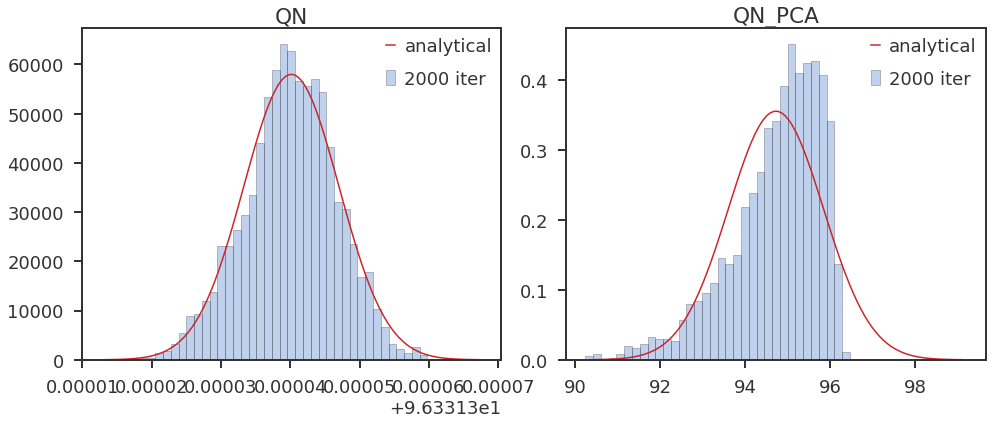

In [27]:
## Shuffle 1000 times, and get Qscore
def shuffle_and_plot(GX, GT, ax, label):
    sigmabeta2 = 2.0 * 2.0
    niter = 2000
    sigmax2 = np.var(GT)
    
    Yt = GX.T
    U, S, Vt = np.linalg.svd(Yt, full_matrices=False)
    S2 = np.square(S)
    S2mod = S2 + sigmax2 / sigmabeta2
    
#     Keff = len(np.where(S2 > 1)[0])
#     GTk = GT[:Keff]
#     Uk = U[:Keff, :][:, :Keff]
#     S2k = S2[:Keff]
#     S2modk = S2mod[:Keff]
    
    W = np.dot(U, np.dot(np.diag(S2 / S2mod), U.T))
    Qscore = np.sum(np.square(np.dot(U.T, GT)) * S2 / S2mod)
    pval, muQ, sigmaQ = pvals_perm(GT.reshape(1, -1), Qscore, W)
#     W = np.dot(Uk, np.dot(np.diag(S2k / S2modk), Uk.T))
#     Qscore = np.sum(np.square(np.dot(Uk.T, GTk)) * S2k / S2modk)
#     pval, muQ, sigmaQ = pvals_perm(GTk.reshape(1, -1), Qscore, W)
    
    Qiter = np.zeros(niter)
    permgt = GT.copy()
    for i in range(niter):
        np.random.shuffle(permgt)
        Qiter[i] = np.sum(np.square(np.dot(U.T, permgt)) * S2 / S2mod)

#     Qiter = np.zeros(niter)
#     permgt = GTk.copy()
#     for i in range(niter):
#         np.random.shuffle(permgt)
#         Qiter[i] = np.sum(np.square(np.dot(Uk.T, permgt)) * S2k / S2modk)
    
    print("====== {:s} ======".format(label))
    print("Qscore:", Qscore)
    print("muQ:", muQ)
    print("sigmaQ:", sigmaQ)
    
    #xmax = np.max(Qiter) + 1.5 * sigmaQ
    #xmin = np.min(Qiter) - 1.5 * sigmaQ
    xmax = muQ + 4.0 * sigmaQ
    xmin = muQ - 4.0 * sigmaQ
    bins = np.linspace(xmin, xmax, 50)
    xbin = [(bins[i] + bins[i+1]) / 2 for i in range(bins.shape[0] - 1)] # centers of the bins
    x = np.linspace(xbin[0], xbin[-1], 100)
    #yhist, _ = np.histogram(Qiter, bins = bins)
    #yfreq = yhist / len(Qiter)
    #fy = interp1d(xbin, yfreq, kind = 'cubic')
    #y = fy(x)
    #ax.plot(x, y, alpha = 1, label = '1000 iter')
    #ax.plot(xbin, yhist)
    ax.hist(Qiter, bins = bins, density = True, alpha = 0.3, label = '{:d} iter'.format(niter))
    
    rv = stats.norm(loc = muQ, scale = sigmaQ)
    ax.plot(x, rv.pdf(x), label = 'analytical')
    
    ax.set_title(label)
    
    return Qiter
    
fig = plt.figure(figsize = (14, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
Qiter_qn = shuffle_and_plot(gx_rand_norm, gt[0, :], ax1, "QN")
Qiter_qn_lm = shuffle_and_plot(gx_rand_pca_norm, gt[0, :], ax2, "QN_PCA")
ax1.legend()
ax2.legend()
plt.tight_layout()
plt.show()